### bd CPS graph basic labor market indicators

bd_CPS_grapher.ipynb

September 20, 2018

@bd_econ

Requires: `cpsYYYY.ft`.

In [27]:
import os
import pandas as pd

os.chdir('/home/bdew/Documents/CPS/data/clean/')

%matplotlib inline

/home/bdew/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


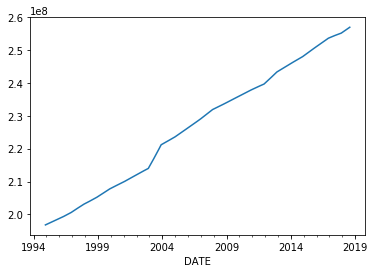

In [30]:
pd.concat(
[(pd.read_feather(f'cps_{year}.ft', nthreads=3)
    .assign()
    .groupby('HRMONTH')['PWSSWGT'].sum()
    .reset_index()
    .assign(DATE=lambda x: pd.to_datetime(f'{year}-' + x.HRMONTH.astype('str') + '-01'))
    .set_index('DATE')['PWSSWGT']) for year in range(1994, 2019)]).rolling(12).mean().plot()

In [48]:
import numpy as np


def divide_two_cols(df_sub):
    return df_sub['UNEMP'].sum() / df_sub['LF'].sum()

In [49]:
d = (pd.read_feather(f'cps_2017.ft', nthreads=3)
   .assign(UNEMP = lambda x: np.where(x['PREMPNOT']==2, x['PWCMPWGT'], 0))
   .assign(LF = lambda x: np.where(x['PREMPNOT'].isin([1, 2]), x['PWCMPWGT'], 0))
   .groupby('HRMONTH').apply(divide_two_cols))
   #.apply(lambda x: x['UNEMP'] / x['LF']))

/home/bdew/miniconda3/lib/python3.6/site-packages/pandas/io/feather_format.py:112: FutureWarning: `nthreads` argument is deprecated, pass `use_threads` instead
  return feather.read_dataframe(path, nthreads=nthreads)


In [ ]:
                 un = np.where(df['PREMPNOT']==2, 1, 0)
                    lf = np.where(df['PREMPNOT'].isin([1, 2]), 1, 0)
                    unrt = (df['PWSSWGT'] * un).sum() / (df['PWSSWGT'] * lf).sum()
                    data[pd.to_datetime(f'{year}-{month}-01')] = unrt * 100